# Classification Project: Adult Census Income (UCI)

## 1. Problem Statement
We build a supervised **binary classification** model to predict whether an individual's annual income is **> $50K** (`income = 1`) or **<= $50K** (`income = 0`) using demographic and employment-related attributes.

## 2. UNSDG Alignment
This project aligns with **UN Sustainable Development Goal 8 (Decent Work and Economic Growth)** because it studies relationships between education, occupation, working hours, and income—key factors that inform policies for productive employment and improved living standards.

## 3. Dataset (required details)
**Dataset:** *Adult / Census Income* (UCI Machine Learning Repository)

- **Created / extracted:** Extracted from the **1994 U.S. Census database** by **Barry Becker**.
- **Donated / published on UCI:** **April 30, 1996**.
- **Access / source:** Downloaded as a CSV file from the UCI Machine Learning Repository.
- **Instances / features:** 48,842 rows and 14 input features (target not included in the 14).
- **Known issues:** Missing values exist for some categorical fields (often encoded as `?`).

**Primary reference:** UCI dataset page (Adult/Census Income).

## 4. Questions this dataset can answer (examples)
1. Which attributes (e.g., education level, occupation, working hours) are most associated with earning **> $50K**?
2. Are higher-income individuals older on average, or do they work more hours per week?
3. How does income vary by education and marital status?

---

> **Note:** The notebook uses a clean sklearn pipeline approach (imputation → encoding/scaling → model), so there is **no data leakage** between train and test.


In [1]:
# Import core libraries for numerical computation and data manipulation
import numpy as np
import pandas as pd

# Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import utilities for model training, validation, and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel

# Import classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Import evaluation metrics for classification tasks
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from sklearn.metrics import roc_auc_score, average_precision_score


# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Enable fast experimentation mode using a subset of the data
# This should be disabled for the final model evaluation
FAST_MODE = False
SAMPLE_FRAC = 0.25

# Set a consistent visual theme for plots
sns.set_theme(style="whitegrid")


## 3. Dataset (Adult / Census Income)

**Source:** UCI Machine Learning Repository (Adult / Census Income). The UCI page states the dataset was **donated on 30 April 1996**, and the extraction was done by **Barry Becker** from the **1994 US Census database**. (Commonly referenced contributors: Ron Kohavi and Barry Becker.)

**How the dataset was accessed in this notebook:** A local CSV file `adult.csv` (same schema as UCI Adult). If you do not have the file, download it from the UCI repository and rename to `adult.csv`.

### 3.1 Attributes (Features)
Each row represents one individual. The target label is `income`.

| Attribute | Type | Brief meaning |
|---|---:|---|
| age | numeric | Age in years |
| workclass | categorical | Employment type (e.g., Private, State-gov, Self-emp) |
| fnlwgt | numeric | Census sampling weight |
| education | categorical | Highest education level |
| education-num | numeric | Education level encoded as an integer |
| marital-status | categorical | Marital status |
| occupation | categorical | Occupation category |
| relationship | categorical | Relationship role in family |
| race | categorical | Race category |
| sex | categorical | Sex (Female/Male) |
| capital-gain | numeric | Capital gains |
| capital-loss | numeric | Capital losses |
| hours-per-week | numeric | Working hours per week |
| native-country | categorical | Country of origin |
| income (target) | categorical | `<=50K` or `>50K` |

### 3.2 Example questions the dataset can answer
1. Which attributes (education, occupation, hours/week, capital-gain, etc.) are most associated with earning **> $50K**?
2. How does **education level** affect the probability of earning **> $50K**?
3. Can we build a model that reliably predicts higher income while controlling for class imbalance?

### 3.3 Initial quality considerations
- The UCI Adult dataset includes **missing values** in some categorical columns (often encoded as `?`).
- The target is typically **imbalanced** (more `<=50K` than `>50K`), so we report **precision, recall, F1**, and also ROC-AUC / PR-AUC where useful.


**Interpretation **

This cell imports all libraries for data handling, visualization, machine learning, and evaluation. A fixed random seed is used so results are reproducible (same split and similar outcomes each run). FAST_MODE allows faster testing by sampling the dataset.

In [2]:
df = pd.read_csv("adult.csv", na_values=["?"])
print("Dataset shape:", df.shape)
display(df.head())

# Remove leading/trailing whitespace from categorical variables
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()
    df.loc[df[col].str.lower() == "nan", col] = np.nan

# Ensure missing values are represented as numpy.nan for sklearn compatibility
df = df.replace({pd.NA: np.nan})

# Define target variable and encode it as binary
TARGET = "income"
y = (df[TARGET] == ">50K").astype(int)
X = df.drop(columns=TARGET)


Dataset shape: (48842, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


Interpretation:
The dataset is first loaded while treating the “?” symbol as missing values. Additional preprocessing is performed to remove leading and trailing whitespace from categorical variables, which helps prevent inconsistent category representations during encoding. The target variable, income, is transformed into a binary outcome where individuals earning more than 50K are encoded as 1 and those earning 50K or less are encoded as 0. This transformation formulates the problem as a binary classification task suitable for supervised learning models.

In [3]:
# Initial data quality checks
print("Missing values by feature:")
display(df.isna().sum()[df.isna().sum() > 0])

print("Number of duplicate rows:", df.duplicated().sum())


Missing values by feature:


,0
workclass,2799
occupation,2809
native-country,857


Number of duplicate rows: 52


Interpretation:
This step identifies missing values and duplicate records in the dataset. These checks help determine whether imputation or data cleaning is necessary before model training.

In [4]:

# Data dictionary (feature descriptions)
data_dict = pd.DataFrame([
    ("age", "numeric (int)", "Age in years."),
    ("workclass", "categorical", "Employer type (e.g., Private, Self-emp, Government, etc.)."),
    ("fnlwgt", "numeric (int)", "Final sampling weight used by the Census Bureau (proxy for representation in population)."),
    ("education", "categorical", "Highest education level (string label)."),
    ("education-num", "numeric (int)", "Education level as an ordered numeric value."),
    ("marital-status", "categorical", "Marital status category."),
    ("occupation", "categorical", "Occupation category (e.g., Exec-managerial, Sales, etc.)."),
    ("relationship", "categorical", "Relationship / household role (e.g., Husband, Wife, Not-in-family)."),
    ("race", "categorical", "Race category."),
    ("sex", "binary categorical", "Sex (Female/Male)."),
    ("capital-gain", "numeric (int)", "Capital gains recorded for the year."),
    ("capital-loss", "numeric (int)", "Capital losses recorded for the year."),
    ("hours-per-week", "numeric (int)", "Hours worked per week."),
    ("native-country", "categorical", "Country of origin."),
    ("income (target)", "binary", "Target: >50K or <=50K annual income.")
], columns=["Attribute", "Type", "Description"])

display(data_dict)


,Attribute,Type,Description
0,age,numeric (int),Age in years.
1,workclass,categorical,"Employer type (e.g., Private, Self-emp, Govern..."
2,fnlwgt,numeric (int),Final sampling weight used by the Census Burea...
3,education,categorical,Highest education level (string label).
4,education-num,numeric (int),Education level as an ordered numeric value.
5,marital-status,categorical,Marital status category.
6,occupation,categorical,"Occupation category (e.g., Exec-managerial, Sa..."
7,relationship,categorical,"Relationship / household role (e.g., Husband, ..."
8,race,categorical,Race category.
9,sex,binary categorical,Sex (Female/Male).


Interpretation:
This data dictionary summarizes each feature in the dataset, including its type and meaning. Clearly documenting the attributes supports better understanding of the data and informs appropriate preprocessing and model selection decisions.

In [5]:
# Define the target variable and separate features from labels
# The income column is converted into a binary target for classification
TARGET = "income"
y = (df[TARGET] == ">50K").astype(int)
X = df.drop(columns=TARGET)

# Summarize the class distribution to identify potential class imbalance
# This helps determine whether stratified sampling and appropriate metrics are needed
class_summary = pd.DataFrame({
    "Class": ["<=50K", ">50K"],
    "Count": y.value_counts().reindex([0, 1]).values,
    "Percent": (y.value_counts(normalize=True).reindex([0, 1]) * 100).round(2).values
})

display(class_summary)


,Class,Count,Percent
0,<=50K,37155,76.07
1,>50K,11687,23.93


Interpretation:
This step prepares the feature matrix and binary target variable and examines the distribution of income classes. Understanding class balance at this stage helps guide model evaluation and validation strategies.

,dtype,n_missing,missing_%,n_unique
occupation,object,2809,5.75,14
workclass,object,2799,5.73,8
native-country,object,857,1.75,41
education,object,0,0.00,16
fnlwgt,int64,0,0.00,28523
age,int64,0,0.00,74
marital-status,object,0,0.00,7
educational-num,int64,0,0.00,16
race,object,0,0.00,5
relationship,object,0,0.00,6


,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
educational-num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
capital-gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
capital-loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
hours-per-week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


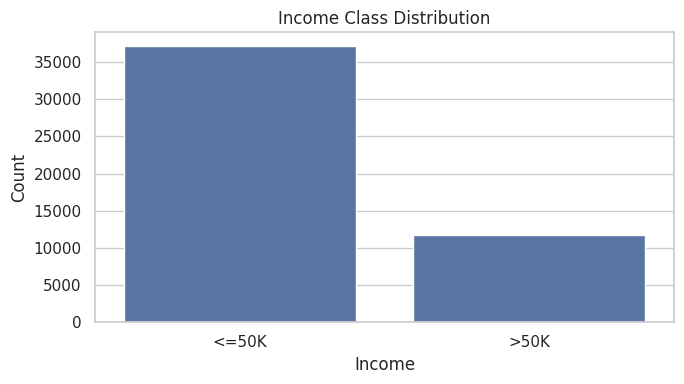

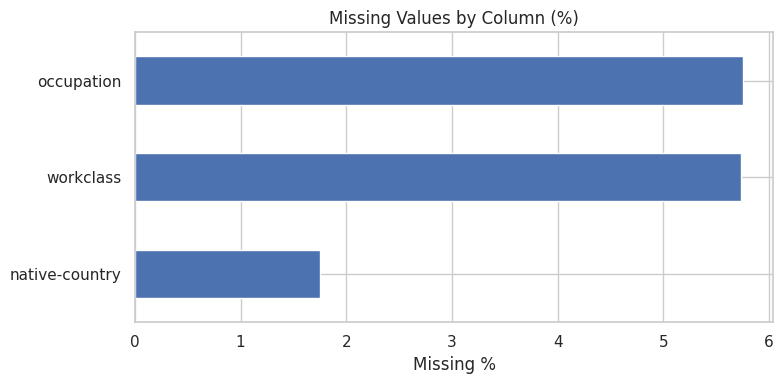

Number of numeric columns: 6
Number of categorical columns: 8


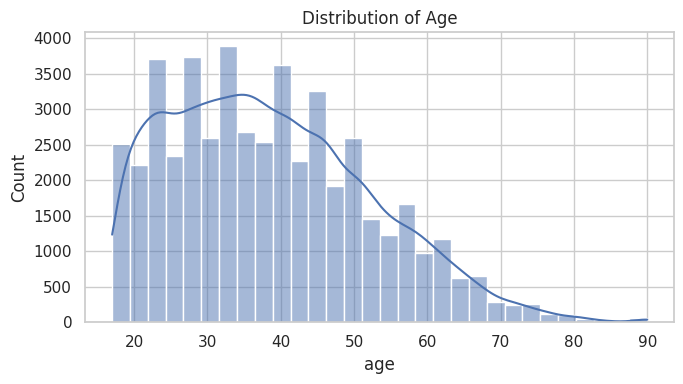

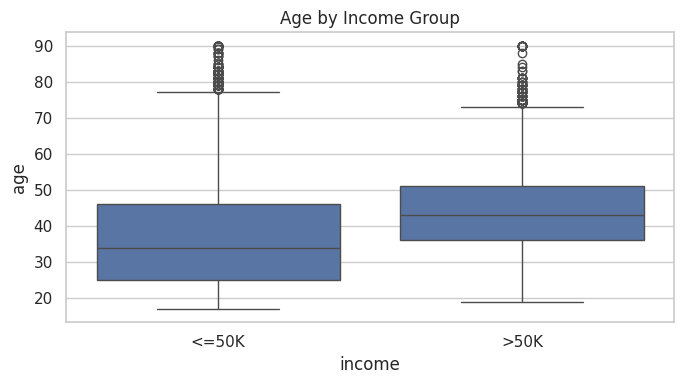

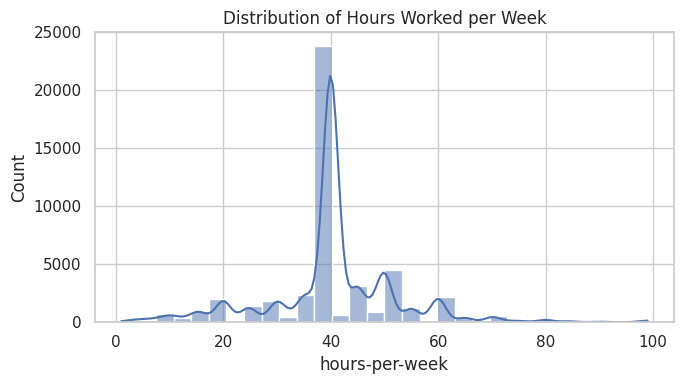

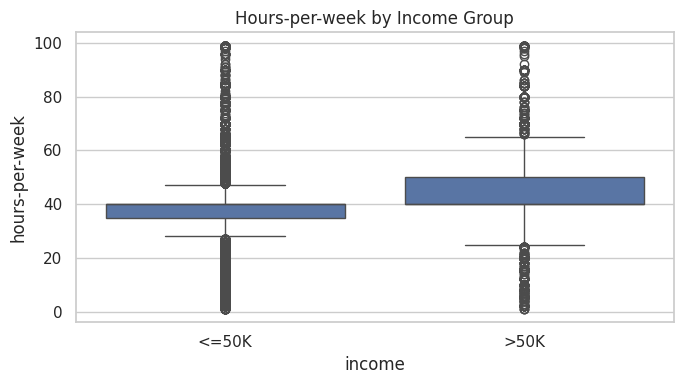

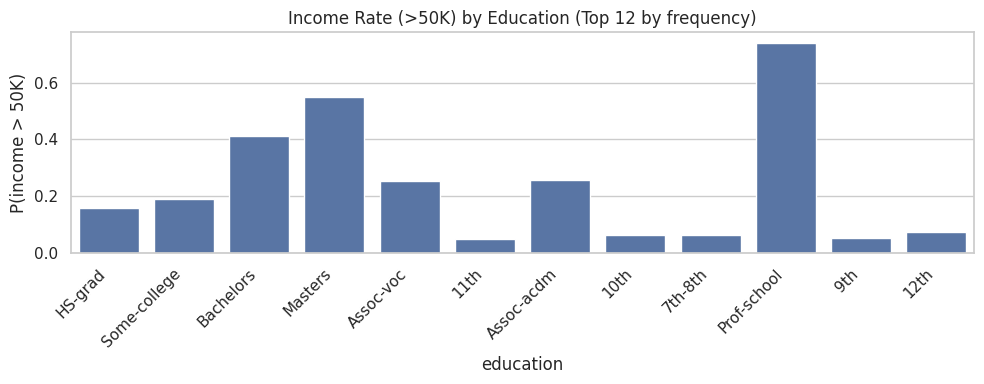

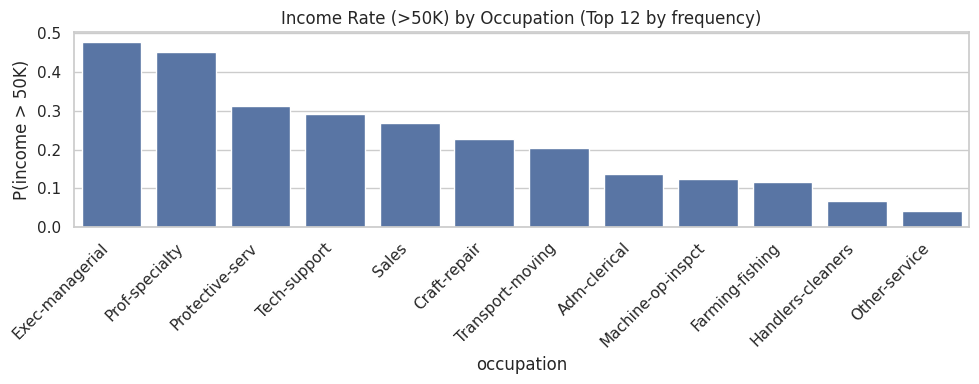

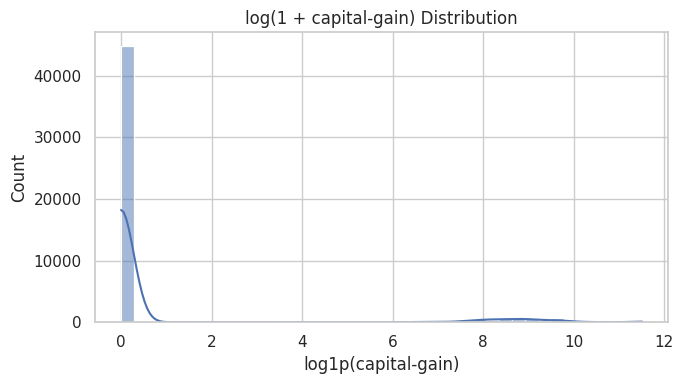

In [6]:
# Exploratory Data Analysis (EDA)

# Basic structure overview
summary = pd.DataFrame({
    "dtype": X.dtypes,
    "n_missing": X.isna().sum(),
    "missing_%": (X.isna().mean() * 100).round(2),
    "n_unique": X.nunique()
}).sort_values("missing_%", ascending=False)

display(summary)

# Summary statistics for numeric features
display(X.describe(include=[np.number]).T)

# Class distribution (visual check for imbalance)
plt.figure(figsize=(7, 4))
sns.countplot(x=y.map({0: "<=50K", 1: ">50K"}))
plt.title("Income Class Distribution")
plt.xlabel("Income")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Missingness overview (only if any missing values exist)
missing_pct = (X.isna().mean() * 100)
miss_nonzero = missing_pct[missing_pct > 0].sort_values()

if len(miss_nonzero) > 0:
    plt.figure(figsize=(8, 4))
    miss_nonzero.plot(kind="barh")
    plt.title("Missing Values by Column (%)")
    plt.xlabel("Missing %")
    plt.tight_layout()
    plt.show()

# Identify numeric and categorical columns (useful for preprocessing later)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Number of numeric columns:", len(num_cols))
print("Number of categorical columns:", len(cat_cols))

# Age: distribution and relationship with income
if "age" in X.columns:
    plt.figure(figsize=(7, 4))
    sns.histplot(data=X, x="age", bins=30, kde=True)
    plt.title("Distribution of Age")
    plt.tight_layout()
    plt.show()

    age_plot = pd.DataFrame({"age": X["age"], "income": y.map({0: "<=50K", 1: ">50K"})})
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=age_plot, x="income", y="age")
    plt.title("Age by Income Group")
    plt.tight_layout()
    plt.show()

# Hours-per-week: distribution and relationship with income
if "hours-per-week" in X.columns:
    plt.figure(figsize=(7, 4))
    sns.histplot(data=X, x="hours-per-week", bins=30, kde=True)
    plt.title("Distribution of Hours Worked per Week")
    plt.tight_layout()
    plt.show()

    hpw_plot = pd.DataFrame({"hours-per-week": X["hours-per-week"], "income": y.map({0: "<=50K", 1: ">50K"})})
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=hpw_plot, x="income", y="hours-per-week")
    plt.title("Hours-per-week by Income Group")
    plt.tight_layout()
    plt.show()

# Education vs income rate (top 12 categories by frequency)
if "education" in X.columns:
    edu_rate = pd.DataFrame({"education": X["education"], "y": y}).groupby("education")["y"].mean()
    edu_count = X["education"].value_counts()
    edu_plot = pd.DataFrame({"income_rate": edu_rate, "count": edu_count}).sort_values("count", ascending=False).head(12)

    plt.figure(figsize=(10, 4))
    sns.barplot(x=edu_plot.index, y=edu_plot["income_rate"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Income Rate (>50K) by Education (Top 12 by frequency)")
    plt.ylabel("P(income > 50K)")
    plt.tight_layout()
    plt.show()

# Occupation vs income rate (top 12 categories by frequency)
if "occupation" in X.columns:
    occ_count = X["occupation"].value_counts().dropna()
    top_occ = occ_count.head(12).index

    occ_rate = pd.DataFrame({"occupation": X["occupation"], "y": y}).dropna().groupby("occupation")["y"].mean()
    occ_plot = occ_rate.loc[top_occ].sort_values(ascending=False)

    plt.figure(figsize=(10, 4))
    sns.barplot(x=occ_plot.index, y=occ_plot.values)
    plt.xticks(rotation=45, ha="right")
    plt.title("Income Rate (>50K) by Occupation (Top 12 by frequency)")
    plt.ylabel("P(income > 50K)")
    plt.tight_layout()
    plt.show()

# Capital-gain: right-skewness (log1p for clearer visualization)
if "capital-gain" in X.columns:
    cg = X["capital-gain"].fillna(0)
    plt.figure(figsize=(7, 4))
    sns.histplot(np.log1p(cg), bins=40, kde=True)
    plt.title("log(1 + capital-gain) Distribution")
    plt.xlabel("log1p(capital-gain)")
    plt.tight_layout()
    plt.show()


Interpretation:
The EDA shows that the target classes are not perfectly balanced, so stratified validation and appropriate metrics are important. Several variables (age, hours-per-week, education, occupation, and capital gains) display noticeable differences between income groups, suggesting they may be strong predictors. Capital-gain is highly right-skewed, indicating the need for robust preprocessing before modeling

In [7]:
# Split into training and testing sets
# Stratification preserves the original class proportions in both splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train/Test shapes:", X_train.shape, X_test.shape)

# Numerical preprocessing: impute missing values using the median and scale features
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical preprocessing: impute missing values using the most frequent category and one-hot encode
categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Apply the appropriate preprocessing to each column type
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)


Train/Test shapes: (39073, 14) (9769, 14)


Interpretation:
The dataset is split into training and testing sets using stratification to preserve the original income class proportions. A preprocessing pipeline is defined to handle missing values and scaling for numeric features and imputation plus one-hot encoding for categorical features. This ensures the models receive clean, properly formatted inputs without data leakage.

## 5.1 Neural Network Model (MLPClassifier)

We implement a **Multi-Layer Perceptron (MLP)** as the neural network classifier.

**Architecture (chosen for tabular data):**
- Input: preprocessed numeric + one-hot categorical features
- Hidden layers: **(64, 32)** neurons
- Activation: **ReLU** (non-linear, works well for deep networks)
- Output layer: **sigmoid**-like probability via sklearn's internal logistic output for binary classification

**Training setup:**
- Loss: **log-loss (cross-entropy)** (default for classification in `MLPClassifier`)
- Optimizer: **Adam** (default, good general-purpose adaptive optimizer)
- Regularization: L2 controlled by `alpha`
- Early stopping: enabled to reduce overfitting

We evaluate using metrics suitable for imbalanced classes: **F1**, **recall**, and (when available) **ROC-AUC/PR-AUC**.



Logistic Regression (Baseline)
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      7431
        >50K       0.74      0.59      0.66      2338

    accuracy                           0.85      9769
   macro avg       0.81      0.76      0.78      9769
weighted avg       0.85      0.85      0.85      9769



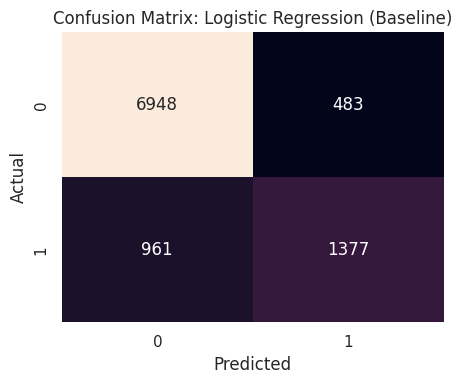


Random Forest (Baseline)
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      7431
        >50K       0.79      0.59      0.68      2338

    accuracy                           0.86      9769
   macro avg       0.83      0.77      0.79      9769
weighted avg       0.86      0.86      0.86      9769



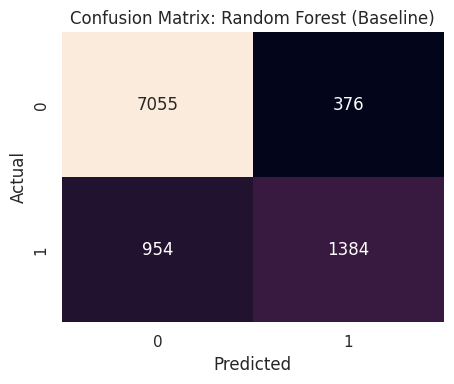


Neural Network MLP (Baseline)
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      7431
        >50K       0.75      0.59      0.66      2338

    accuracy                           0.86      9769
   macro avg       0.82      0.77      0.79      9769
weighted avg       0.85      0.86      0.85      9769



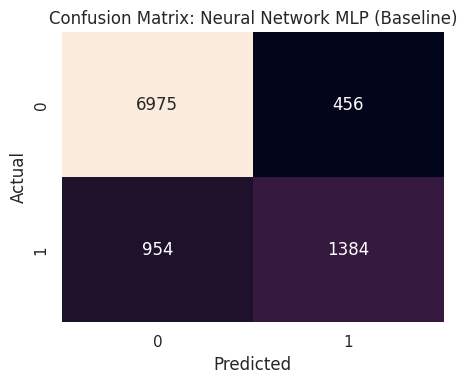

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
1,Random Forest (Baseline),0.8639,0.7864,0.592,0.6755,0.9170,0.8067
2,Neural Network MLP (Baseline),0.8557,0.7522,0.592,0.6625,0.9104,0.7783
0,Logistic Regression (Baseline),0.8522,0.7403,0.589,0.6560,0.9042,0.7633


In [13]:
# Train and evaluate baseline classification models using a shared preprocessing pipeline


def evaluate(model, name):
    """
    Train a classification model and evaluate its performance on the test set.

    In addition to accuracy, precision, recall, and F1-score, the function also
    computes ROC-AUC and PR-AUC when the model provides predicted probabilities.
    PR-AUC is often informative when the positive class is less frequent.

    Parameters
    ----------
    model : sklearn estimator or Pipeline
        A scikit-learn compatible classification model or pipeline.
    name : str
        Descriptive name of the model for reporting and comparison.

    Returns
    -------
    dict
        Dictionary containing evaluation metrics for later model comparison.
    """

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict class labels on the test data
    pred = model.predict(X_test)

    # Get predicted probabilities for the positive class when available
    proba = None
    if hasattr(model, "predict_proba"):
        try:
            proba = model.predict_proba(X_test)[:, 1]
        except Exception:
            proba = None

    # Print a detailed classification report for both income classes
    print(f"\n{name}")
    print(classification_report(y_test, pred, target_names=["<=50K", ">50K"], zero_division=0))

    # Visualize the confusion matrix to understand classification errors
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(4.7, 4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Store the main evaluation metrics for model comparison
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred, average="binary", pos_label=1, zero_division=0),
        "Recall": recall_score(y_test, pred, average="binary", pos_label=1, zero_division=0),
        "F1": f1_score(y_test, pred, average="binary", pos_label=1, zero_division=0),
        "ROC-AUC": np.nan,
        "PR-AUC": np.nan
    }

    # Add probability-based metrics if supported
    if proba is not None:
        metrics["ROC-AUC"] = roc_auc_score(y_test, proba)
        metrics["PR-AUC"] = average_precision_score(y_test, proba)

    return metrics


logreg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=3000, solver="saga", n_jobs=-1, random_state=RANDOM_STATE))
])

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=150,max_depth=20, n_jobs=-1, random_state=RANDOM_STATE))
])

mlp = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        early_stopping=True,
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=60 if FAST_MODE else 150,
        random_state=RANDOM_STATE
    ))
])

baseline_results = []
baseline_results.append(evaluate(logreg, "Logistic Regression (Baseline)"))
baseline_results.append(evaluate(rf, "Random Forest (Baseline)"))
baseline_results.append(evaluate(mlp, "Neural Network MLP (Baseline)"))

baseline_df = pd.DataFrame(baseline_results).sort_values("F1", ascending=False)
display(baseline_df.round(4))


Interpretation:
Baseline models were evaluated using standard classification metrics and confusion matrices to compare predictive performance. Where available, ROC-AUC and PR-AUC were also computed using predicted probabilities to provide a threshold-independent assessment of class separation, with PR-AUC being particularly informative under class imbalance.

Best Logistic Regression parameters: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Best Logistic Regression CV F1: 0.6787
Best Random Forest parameters: {'clf__class_weight': None, 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best Random Forest CV F1: 0.6811

Logistic Regression (Tuned)
              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.86      7431
        >50K       0.56      0.84      0.68      2338

    accuracy                           0.81      9769
   macro avg       0.75      0.82      0.77      9769
weighted avg       0.85      0.81      0.82      9769



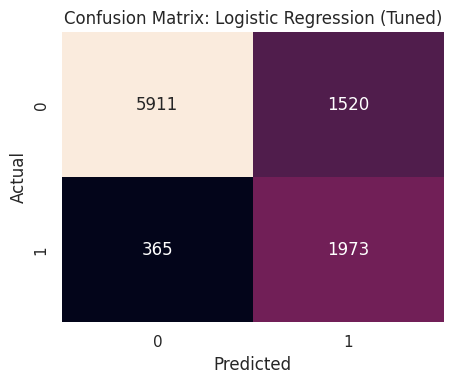


Random Forest (Tuned)
              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91      7431
        >50K       0.78      0.62      0.69      2338

    accuracy                           0.87      9769
   macro avg       0.83      0.78      0.80      9769
weighted avg       0.86      0.87      0.86      9769



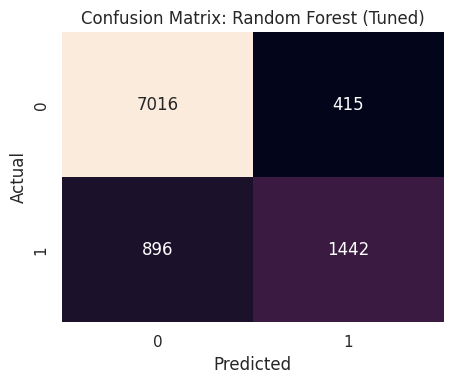

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
1,Random Forest (Tuned),0.8658,0.7765,0.6168,0.6875,0.9178,0.8079
0,Logistic Regression (Tuned),0.8070,0.5648,0.8439,0.6767,0.9044,0.7620


In [9]:
# Hyperparameter tuning using stratified cross-validation
# Stratification preserves the original class proportions in each fold
# A smaller number of folds is used to reduce computational cost
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Grid search for Logistic Regression
# The search focuses on regularization strength and class weighting
gs_lr = GridSearchCV(
    logreg,
    param_grid={
        "clf__penalty": ["l2"],
        "clf__C": [0.1, 1],
        "clf__class_weight": [None, "balanced"],
        "clf__solver": ["saga"],
    },
    scoring="f1",
    cv=cv,
    n_jobs=-1
)
gs_lr.fit(X_train, y_train)

# Grid search for Random Forest
# The search explores tree depth and node-splitting parameters
gs_rf = GridSearchCV(
    rf,
    param_grid={
        "clf__n_estimators": [100],
        "clf__max_depth": [None, 20],
        "clf__min_samples_split": [2, 10],
        "clf__min_samples_leaf": [1, 2],
        "clf__class_weight": [None],
    },
    scoring="f1",
    cv=cv,
    n_jobs=-1
)
gs_rf.fit(X_train, y_train)

# Display the best hyperparameters and corresponding cross-validated F1-scores
print("Best Logistic Regression parameters:", gs_lr.best_params_)
print("Best Logistic Regression CV F1:", round(gs_lr.best_score_, 4))
print("Best Random Forest parameters:", gs_rf.best_params_)
print("Best Random Forest CV F1:", round(gs_rf.best_score_, 4))

# Extract the best estimators identified by GridSearchCV
best_lr = gs_lr.best_estimator_
best_rf = gs_rf.best_estimator_

# Evaluate the tuned models on the held-out test set
tuned_results = []
tuned_results.append(evaluate(best_lr, "Logistic Regression (Tuned)"))
tuned_results.append(evaluate(best_rf, "Random Forest (Tuned)"))

# Compare tuned model performance using test-set metrics
display(pd.DataFrame(tuned_results).round(4).sort_values("F1", ascending=False))


Interpretation:
Stratified GridSearchCV was applied to tune key hyperparameters of Logistic Regression and Random Forest using F1-score as the optimization metric. The best-performing configurations were selected based on cross-validation results and subsequently evaluated on the test set, enabling a fair comparison with the baseline models.


Final Logistic Regression
              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.86      7431
        >50K       0.56      0.84      0.68      2338

    accuracy                           0.81      9769
   macro avg       0.75      0.82      0.77      9769
weighted avg       0.85      0.81      0.82      9769



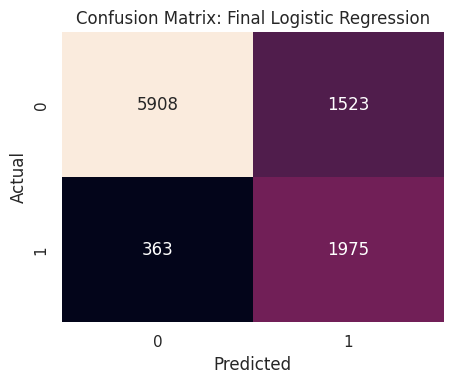


Final Random Forest
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      7431
        >50K       0.77      0.61      0.68      2338

    accuracy                           0.86      9769
   macro avg       0.83      0.78      0.80      9769
weighted avg       0.86      0.86      0.86      9769



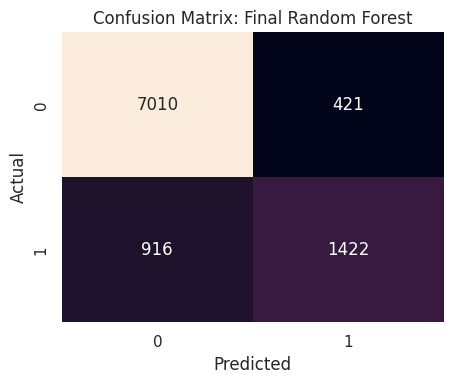

,Model,Selected Features,CV F1,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
1,Final Random Forest,18,0.6676,0.8631,0.7716,0.6082,0.6802,0.9133,0.8035
0,Final Logistic Regression,86,0.6759,0.8069,0.5646,0.8447,0.6768,0.9043,0.7621


In [10]:
#Feature Selection and Final Model Evaluation
def count_selected_features_fitted(pipeline):
    """Return the number of selected transformed features after the pipeline has been fitted."""
    selector = pipeline.named_steps.get("select", None)
    if selector is None or not hasattr(selector, "get_support"):
        return None
    return int(selector.get_support().sum())


# Build final models with feature selection (embedded method) + tuned classifiers
lr_fs = Pipeline(steps=[
    ("prep", preprocess),
    ("select", SelectFromModel(
        LogisticRegression(
            penalty="l1",
            solver="saga",
            C=1.0,
            max_iter=2000,
            random_state=RANDOM_STATE
        )
    )),
    ("clf", LogisticRegression(
        max_iter=3000,
        solver="saga",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        C=gs_lr.best_params_.get("clf__C", 1.0),
        class_weight=gs_lr.best_params_.get("clf__class_weight", None),
        penalty=gs_lr.best_params_.get("clf__penalty", "l2")
    ))
])

rf_fs = Pipeline(steps=[
    ("prep", preprocess),
    ("select", SelectFromModel(
        RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    )),
    ("clf", RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        n_estimators=gs_rf.best_params_.get("clf__n_estimators", 200),
        max_depth=gs_rf.best_params_.get("clf__max_depth", None),
        min_samples_split=gs_rf.best_params_.get("clf__min_samples_split", 2),
        min_samples_leaf=gs_rf.best_params_.get("clf__min_samples_leaf", 1),
        class_weight=gs_rf.best_params_.get("clf__class_weight", None),
    ))
])

final_results = []

for model, name in [(lr_fs, "Final Logistic Regression"), (rf_fs, "Final Random Forest")]:
    # Cross-validated estimate on the training set
    cv_f1 = cross_val_score(model, X_train, y_train, cv=3, scoring="f1", n_jobs=-1).mean()

    # Fit once on full training data and evaluate on the test set
    model.fit(X_train, y_train)
    n_feat = count_selected_features_fitted(model)

    metrics = evaluate(model, name)   # removed show_curves to match your evaluate() signature
    metrics["Selected Features"] = n_feat
    metrics["CV F1"] = cv_f1

    final_results.append(metrics)

final_table = pd.DataFrame(final_results)

cols = ["Model", "Selected Features", "CV F1", "Accuracy", "Precision", "Recall", "F1", "ROC-AUC", "PR-AUC"]
final_table = final_table[[c for c in cols if c in final_table.columns]].round(4)

display(final_table.sort_values("F1", ascending=False))


**Feature Selection (Embedded Methods)**
Embedded feature selection is applied because it performs feature selection as part of the model training process, ensuring tight integration between learning and selection.

**Logistic Regression (L1 penalty):** L1 regularization drives less informative coefficients to exactly zero, allowing the model to retain only the most relevant encoded features.
Random Forest feature importance: Tree-based models estimate feature importance using impurity reduction; SelectFromModel selects features that exceed a specified importance threshold.

This approach is well suited to the dataset, which contains many categorical variables that expand into a high-dimensional, sparse feature space after one-hot encoding. Feature selection helps reduce dimensionality, improve generalization, and enhance interpretability.